# RetinaLiteNet - Model Replication

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


#### Setup and Imports

In [ ]:
import os
import torch
from torchvision import transforms
import torch.nn as nn
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import random
import numpy as np
import cv2
from torch.utils.data import Dataset, DataLoader
from typing import Tuple, List

from google.colab import drive
# drive.mount('/content/drive/Shareddrives')
%cd /content/drive/MyDrive/DL Final Project
base_data_path = "/content/drive/MyDrive/DL Final Project/preprocessed_data/"

/content/drive/.shortcut-targets-by-id/1uPpg4Yr8uev2brz5QIGI5ObT-zin6hvX/DL Final Project


In [ ]:
def convert_to_tensor(image_path: str) -> torch.Tensor:
    image = Image.open(image_path).convert("RGB")
    to_tensor = transforms.ToTensor()
    image_tensor = to_tensor(image)
    return image_tensor

input_folder = "preprocessed_data/train/input/"
segment_folder = "preprocessed_data/train/segments/"

print("Opening preprocessed data...")
image_names = [f.split('.')[0] for f in os.listdir(input_folder)]
print(f"There are {len(image_names)} preprocessed images")
print(image_names)

Opening preprocessed data...
There are 30 preprocessed images
['im0003', 'im0004', 'im0001', 'im0081', 'im0002', 'im0077', 'im0044', 'im0005', 'im0139', 'im0162', 'DRIVE_21', 'DRIVE_23', 'DRIVE_24', 'DRIVE_26', 'DRIVE_25', 'DRIVE_22', 'DRIVE_27', 'DRIVE_28', 'DRIVE_29', 'DRIVE_30', 'DRIVE_31', 'DRIVE_32', 'DRIVE_33', 'DRIVE_34', 'DRIVE_35', 'DRIVE_36', 'DRIVE_37', 'DRIVE_38', 'DRIVE_39', 'DRIVE_40']


#### Data Augmentation Pipeline

In [ ]:
# 1. dropout
def apply_dropout(img: torch.Tensor, mask: torch.Tensor, p: float = 0.1) -> Tuple[torch.Tensor, torch.Tensor]:
    img_out = F.dropout(img, p=p, training=True)
    mask = mask.mean(dim=0, keepdim=True)
    return img_out, mask

# 2. White Noise
def add_white_noise(img: torch.Tensor, mask: torch.Tensor, mean: float = 0.0, std: float = 0.05) -> Tuple[torch.Tensor, torch.Tensor]:
    noise = torch.randn_like(img) * std + mean
    noisy = torch.clamp(img + noise, 0.0, 1.0)
    mask = mask.mean(dim=0, keepdim=True)
    return noisy, mask

# Gamma Correction
def gamma_correction(img: torch.Tensor, mask: torch.Tensor, gamma: float = 1.5) -> Tuple[torch.Tensor, torch.Tensor]:
    corrected = torch.clamp(img ** gamma, 0.0, 1.0)
    mask = mask.mean(dim=0, keepdim=True)
    return corrected, mask

# 4. Histogram Equalization
def histogram_equalization(img: torch.Tensor, mask: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
    np_img = (img.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
    lab = cv2.cvtColor(np_img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    merged = cv2.merge((cl, a, b))
    eq = cv2.cvtColor(merged, cv2.COLOR_LAB2RGB)
    eq = torch.tensor(eq / 255.0, dtype=torch.float32).permute(2, 0, 1)
    mask = mask.mean(dim=0, keepdim=True)
    return eq, mask

# 5. Blur
def apply_blur(img: torch.Tensor, mask: torch.Tensor, kernel_size: int = 5) -> Tuple[torch.Tensor, torch.Tensor]:
    np_img = (img.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
    blurred = cv2.GaussianBlur(np_img, (kernel_size, kernel_size), 0)
    blurred_t = torch.tensor(blurred / 255.0, dtype=torch.float32).permute(2, 0, 1)
    mask = mask.mean(dim=0, keepdim=True)
    return blurred_t, mask

# 6. Elastic Deformation - both image & mask
def elastic_deformation(img: torch.Tensor, mask: torch.Tensor, alpha: float = 34, sigma: float = 4):
    """
    Apply the same elastic deformation to both image and mask.
    """
    np_img = img.permute(1, 2, 0).numpy()
    np_mask = mask.permute(1, 2, 0).numpy()
    random_state = np.random.RandomState(None)
    shape = np_img.shape[:2]

    # Generate displacement fields
    dx = cv2.GaussianBlur((random_state.rand(*shape) * 2 - 1), (17, 17), sigma) * alpha
    dy = cv2.GaussianBlur((random_state.rand(*shape) * 2 - 1), (17, 17), sigma) * alpha

    x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
    map_x = (x + dx).astype(np.float32)
    map_y = (y + dy).astype(np.float32)
    img_def = np.zeros_like(np_img)
    mask_def = np.zeros_like(np_mask)

    for c in range(np_img.shape[2]):
        img_def[..., c] = cv2.remap(
            np_img[..., c], map_x, map_y,
            interpolation=cv2.INTER_LINEAR,
            borderMode=cv2.BORDER_REFLECT
        )
        mask_def[..., c] = cv2.remap(
            np_mask[..., c], map_x, map_y,
            interpolation=cv2.INTER_NEAREST,
            borderMode=cv2.BORDER_REFLECT
        )
    img_out = torch.tensor(img_def, dtype=torch.float32).permute(2, 0, 1)
    mask_out = torch.tensor(mask_def, dtype=torch.float32).permute(2, 0, 1)

    mask_out = mask_out.mean(dim=0, keepdim=True)

    return img_out, mask_out

# 7. Random Flip — both image & mask
def random_flip(img: torch.Tensor, mask: torch.Tensor):
    if random.random() > 0.5:
        img = TF.hflip(img)
        mask = TF.hflip(mask)
    if random.random() > 0.5:
        img = TF.vflip(img)
        mask = TF.vflip(mask)
    mask = mask.mean(dim=0, keepdim=True)
    return img, mask

# 8. Shear — both image & mask
def apply_shear(img: torch.Tensor, mask: torch.Tensor, degrees: float = 10):
    shear = random.uniform(-degrees, degrees)
    img_out = TF.affine(img, angle=0, translate=[0, 0], scale=1.0, shear=[shear])
    mask_out = TF.affine(mask, angle=0, translate=[0, 0], scale=1.0, shear=[shear])
    mask_out = mask_out.mean(dim=0, keepdim=True)
    return img_out, mask_out

# 9. Sharpen
def apply_sharpening(img: torch.Tensor, mask: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
    np_img = (img.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
    kernel = np.array([[0, -1, 0],
                       [-1, 5, -1],
                       [0, -1, 0]])
    sharp = cv2.filter2D(np_img, -1, kernel)
    sharp_t = torch.tensor(sharp / 255.0, dtype=torch.float32).permute(2, 0, 1)
    mask = mask.mean(dim=0, keepdim=True)
    return sharp_t, mask

# 10. Saturation
def boost_saturation(img: torch.Tensor, mask: torch.Tensor, factor: float = 1.5) -> Tuple[torch.Tensor, torch.Tensor]:
    pil_img = TF.to_pil_image(img)
    enhancer = transforms.ColorJitter(saturation=factor)
    img_out = enhancer(pil_img)
    mask = mask.mean(dim=0, keepdim=True)
    return TF.to_tensor(img_out), mask

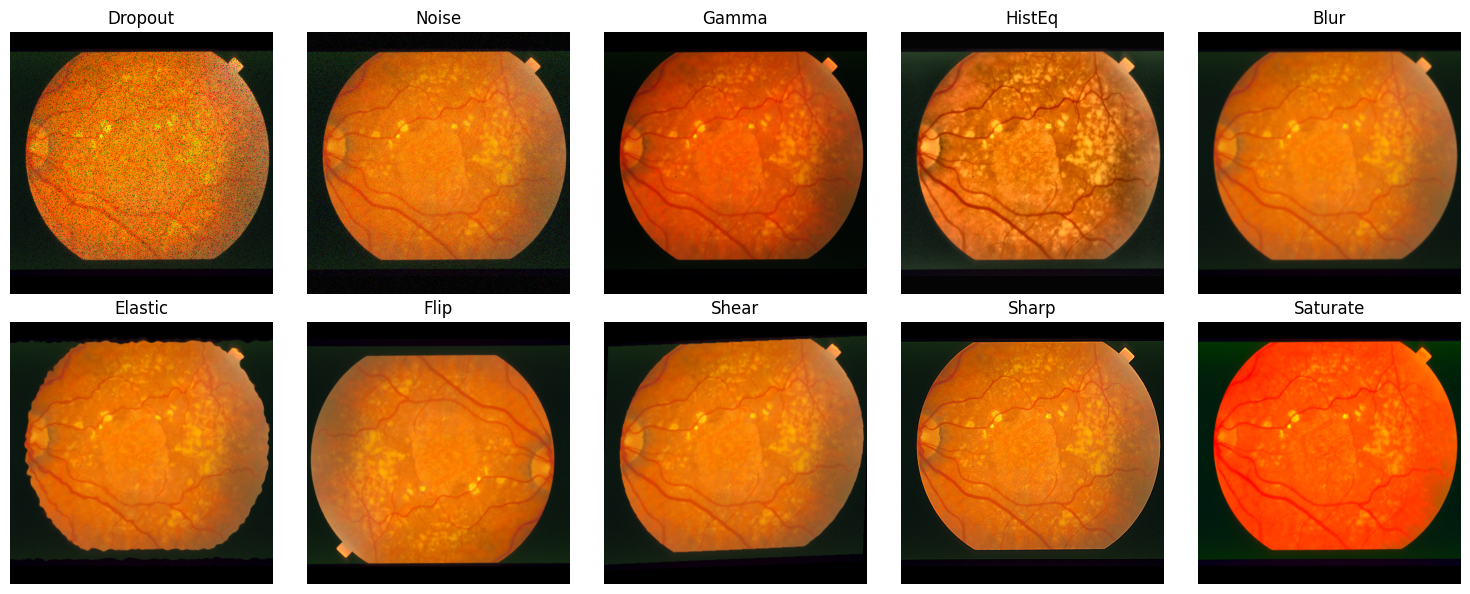

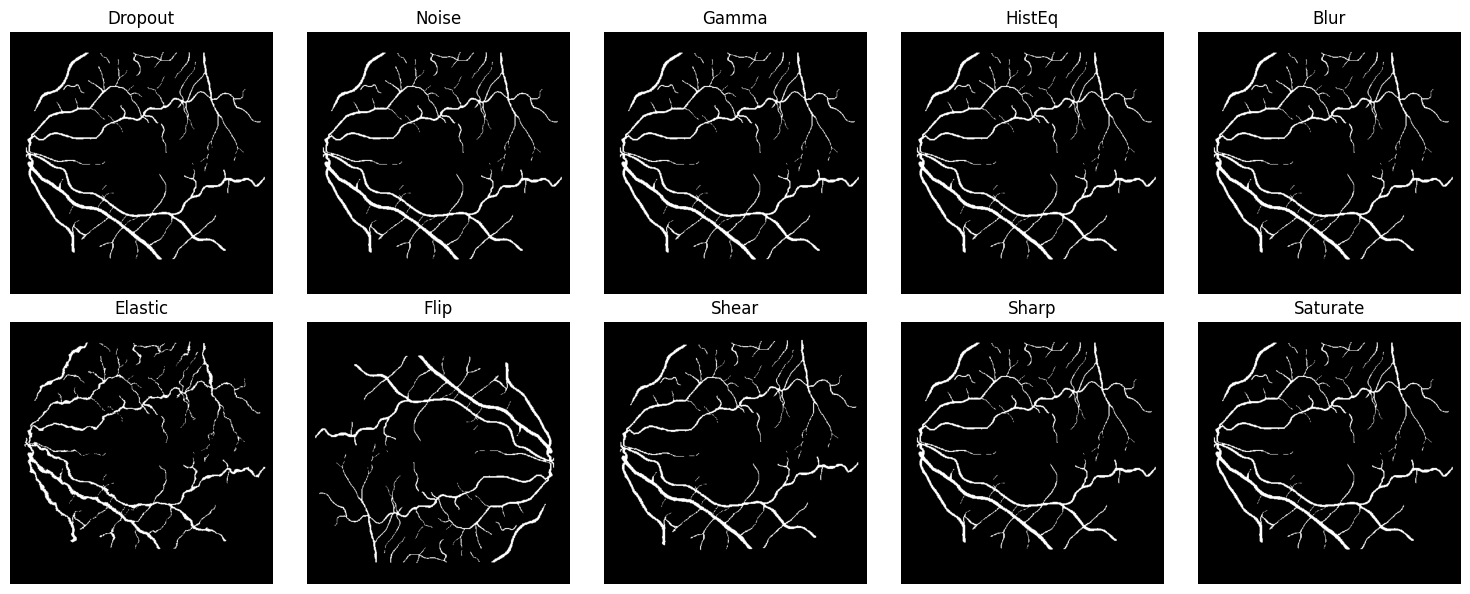

In [ ]:
def augment_image(image_tensor, mask_tensor) -> List[Tuple]:
  variations = []
  variations.append(apply_dropout(image_tensor, mask_tensor))
  variations.append(add_white_noise(image_tensor, mask_tensor))
  variations.append(gamma_correction(image_tensor, mask_tensor))
  variations.append(histogram_equalization(image_tensor, mask_tensor))
  variations.append(apply_blur(image_tensor, mask_tensor))
  variations.append(elastic_deformation(image_tensor, mask_tensor))
  variations.append(random_flip(image_tensor, mask_tensor))
  variations.append(apply_shear(image_tensor, mask_tensor))
  variations.append(apply_sharpening(image_tensor, mask_tensor))
  variations.append(boost_saturation(image_tensor, mask_tensor))

  return variations

# select image - mask pair
sample_image = convert_to_tensor(f"{input_folder}/{image_names[0]}.png")
sample_segment = convert_to_tensor(f"{segment_folder}/{image_names[0]}.png")
# gather all augmentations
variations = augment_image(sample_image, sample_segment)

titles = [
    "Dropout", "Noise", "Gamma", "HistEq", "Blur",
    "Elastic", "Flip", "Shear", "Sharp", "Saturate"
]
# plot image augmentations
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, (variation, title) in enumerate(zip(variations, titles)):
    variation = variation[0]
    ax = axes[i // 5, i % 5]
    ax.imshow(variation.permute(1, 2, 0).numpy().clip(0, 1))
    ax.set_title(title)
    ax.axis("off")

plt.tight_layout()
plt.show()

# plot mask pairing of image augmentations
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, (variation, title) in enumerate(zip(variations, titles)):
    variation = variation[1]
    ax = axes[i // 5, i % 5]
    ax.imshow(variation.permute(1, 2, 0).numpy().clip(0, 1), cmap="grey")
    ax.set_title(title)
    ax.axis("off")

plt.tight_layout()
plt.show()

#### Dataset

In [ ]:
class AugmentedImageDataset(Dataset):
    def __init__(self, image_names, input_folder, segment_folder, augment_fn, img_to_tensor):
        self.samples = []
        for name in image_names:
            img_path = f"{input_folder}{name}.png"
            mask_path = f"{segment_folder}{name}.png"
            img_tensor = img_to_tensor(img_path)
            mask_tensor = img_to_tensor(mask_path)

            variations = [(img_tensor, mask_tensor)] + augment_fn(img_tensor, mask_tensor)
            for aug_img, aug_mask in variations:
                self.samples.append((aug_img, aug_mask, name))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_tensor, mask_tensor, name = self.samples[idx]
        if mask_tensor.shape[0] == 3:
          mask_tenor = mask_tensor.mean(dim=0, keepdim=True)

        return img_tensor, mask_tensor, name

In [ ]:
dataset = AugmentedImageDataset(
    image_names=image_names,
    input_folder=input_folder,
    segment_folder=segment_folder,
    augment_fn=augment_image,
    img_to_tensor=convert_to_tensor
)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

print(f"Created {len(dataset)} training examples")

for i, (img, mask, name) in enumerate(dataloader):
  print(img.shape)
  print(mask.shape)
  print(name)
  break

Created 330 training examples


RuntimeError: stack expects each tensor to be equal size, but got [1, 512, 512] at entry 0 and [3, 512, 512] at entry 1

## Model Defenition

In [ ]:
class ChannelAttention(nn.Module):
    def __init__(self, channels: int, reduction: int):
        super().__init__()
        reduction = max(1, reduction)
        hidden = max(1, channels // reduction)
        self.mlp = nn.Sequential(
            nn.Linear(channels, hidden, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(hidden, channels, bias=False),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        b, c, _, _ = x.shape
        avg = F.adaptive_avg_pool2d(x, 1).view(b, c)
        max_ = F.adaptive_max_pool2d(x, 1).view(b, c)
        attn = self.mlp(avg) + self.mlp(max_)
        scale = torch.sigmoid(attn).view(b, c, 1, 1)
        return x * scale

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size: int):
        super().__init__()
        padding = kernel_size // 2
        self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=padding, bias=False)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        avg = torch.mean(x, dim=1, keepdim=True)
        max_, _ = torch.max(x, dim=1, keepdim=True)
        attn = torch.cat([avg, max_], dim=1)
        scale = torch.sigmoid(self.conv(attn))
        return x * scale

class CBAM(nn.Module):
    def __init__(self, channels: int, reduction: int = 1, spatial_kernel: int = 7):
        super().__init__()
        self.channel_attn = ChannelAttention(channels, reduction)
        self.spatial_attn = SpatialAttention(spatial_kernel)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.channel_attn(x)
        x = self.spatial_attn(x)
        return x


In [ ]:
class RetinaLiteEncoder(nn.Module):

    def __init__(self):
        super().__init__()
        self.enc1 = nn.Sequential(
            nn.Conv2d(3, 12, kernel_size=3, padding=1),
            nn.BatchNorm2d(12),
            nn.ReLU(inplace=True),
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.enc2 = nn.Sequential(
            nn.Conv2d(12, 24, kernel_size=3, padding=1),
            nn.BatchNorm2d(24),
            nn.ReLU(inplace=True),
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.enc3 = nn.Sequential(
            nn.Conv2d(24, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, list[torch.Tensor]]:
        skip1 = self.enc1(x)
        x = self.pool1(skip1)

        skip2 = self.enc2(x)
        x = self.pool2(skip2)

        bottleneck = self.enc3(x)
        skips = [skip1, skip2]
        return bottleneck, skips


class MHABottleneck(nn.Module):

    def __init__(self, channels: int = 64, num_heads: int = 4, dropout: float = 0.0):
        super().__init__()
        self.channels = channels
        self.attn = nn.MultiheadAttention(
            embed_dim=channels,
            num_heads=num_heads,
            dropout=dropout,
            batch_first=True,
        )
        self.fuse = nn.Sequential(
            nn.Conv2d(channels * 2, channels, kernel_size=1),
            nn.BatchNorm2d(channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        b, c, h, w = x.shape
        tokens = x.permute(0, 2, 3, 1).reshape(b, h * w, c)
        attn_out, _ = self.attn(tokens, tokens, tokens)
        attn_map = attn_out.reshape(b, h, w, c).permute(0, 3, 1, 2)
        fused = torch.cat([x, attn_map], dim=1)
        out = self.fuse(fused)
        return out


class RetinaLiteDecoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.up1 = nn.ConvTranspose2d(64, 24, kernel_size=2, stride=2)
        self.skip_attn2 = CBAM(24)
        self.fuse1 = nn.Sequential(
            nn.Conv2d(24 + 24, 24, kernel_size=3, padding=1),
            nn.BatchNorm2d(24),
            nn.ReLU(inplace=True),
        )

        self.up2 = nn.ConvTranspose2d(24, 12, kernel_size=2, stride=2)
        self.skip_attn1 = CBAM(12)
        self.fuse2 = nn.Sequential(
            nn.Conv2d(12 + 12, 12, kernel_size=3, padding=1),
            nn.BatchNorm2d(12),
            nn.ReLU(inplace=True),
        )

    def forward(self, x: torch.Tensor, skips: list[torch.Tensor]) -> torch.Tensor:
        skip1, skip2 = skips
        skip2 = self.skip_attn2(skip2)

        x = self.up1(x)
        x = torch.cat([x, skip2], dim=1)
        x = self.fuse1(x)

        skip1 = self.skip_attn1(skip1)
        x = self.up2(x)
        x = torch.cat([x, skip1], dim=1)
        x = self.fuse2(x)
        return x


class RetinaLiteNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = RetinaLiteEncoder()
        self.bottleneck = MHABottleneck()
        self.decoder = RetinaLiteDecoder()
        self.bv_head = nn.Conv2d(12, 1, kernel_size=1)
        # self.od_head = nn.Conv2d(12, 1, kernel_size=1)

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        bottleneck, skips = self.encoder(x)
        fused = self.bottleneck(bottleneck)
        features = self.decoder(fused, skips)
        bv = self.bv_head(features)
        # od = self.od_head(features)
        # return bv, od
        return bv

## Model Initialization and Training

In [ ]:
# model = RetinaLiteNet()
# dummy = torch.randn(1, 3, 512, 512)
# bv = model(dummy)
# print("BV head output:", bv.shape)
# # print("OD head output:", od.shape)
# total_params = sum(p.numel() for p in model.parameters())
# print("Total parameters:", total_params)

In [ ]:
import os, torch
from torch.utils.data import DataLoader

img_dir   = "/content/drive/MyDrive/DL Final Project/preprocessed_data/train/input/"
mask_dir  = "/content/drive/MyDrive/DL Final Project/preprocessed_data/train/segments/"

all_names = sorted(os.path.splitext(f)[0] for f in os.listdir(img_dir) if f.endswith(".png"))

g = torch.Generator().manual_seed(42)
n = len(all_names)
n_test = int(0.2 * n)
perm = torch.randperm(n, generator=g).tolist()
test_names  = [all_names[i] for i in perm[:n_test]]
train_names = [all_names[i] for i in perm[n_test:]]

def collate_rgb1(batch):
    imgs, masks, names = zip(*batch)

    imgs  = [x if x.shape[0] == 3 else x.repeat(3,1,1) for x in imgs]
    masks = [m if m.shape[0] == 1 else m.mean(dim=0, keepdim=True) for m in masks]

    imgs  = torch.stack(imgs, 0)
    masks = torch.stack(masks, 0)

    imgs  = F.interpolate(imgs, scale_factor=0.5)
    masks = F.interpolate(masks, scale_factor=0.5)

    return imgs, masks, list(names)

train_dataset = AugmentedImageDataset(
    image_names=train_names,
    input_folder=img_dir,
    segment_folder=mask_dir,
    augment_fn=augment_image,
    img_to_tensor=convert_to_tensor,
)

test_dataset = AugmentedImageDataset(
    image_names=test_names,
    input_folder=img_dir,
    segment_folder=mask_dir,
    augment_fn=lambda x, y: [],
    img_to_tensor=convert_to_tensor,
)

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  num_workers=2, pin_memory=True, collate_fn=collate_rgb1)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True, collate_fn=collate_rgb1)


In [ ]:
lr = 0.001
epochs = 300

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RetinaLiteNet()
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCEWithLogitsLoss()

train_losses = []
test_losses = []



In [ ]:
epoch_bar = tqdm(range(1, epochs + 1), desc="epochs")
for epoch in epoch_bar:
    model.train()
    train_loss = 0.0
    train_steps = 0
    for images, bv_masks, _ in train_loader:
        images = images.to(device, non_blocking=True)
        bv_masks = bv_masks.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        bv_logits = model(images)
        loss = criterion(bv_logits, bv_masks)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_steps += 1

    model.eval()
    test_loss = 0.0
    test_steps = 0
    with torch.no_grad():
        for images, bv_masks, _ in test_loader:
            images = images.to(device, non_blocking=True)
            bv_masks = bv_masks.to(device, non_blocking=True)
            bv_logits = model(images)
            loss = criterion(bv_logits, bv_masks)
            test_loss += loss.item()
            test_steps += 1

    avg_train = train_loss / max(1, train_steps)
    avg_test = test_loss / max(1, test_steps)

    train_losses.append(avg_train)
    test_losses.append(avg_test)

    epoch_bar.set_postfix(train=f"{avg_train:.4f}", test=f"{avg_test:.4f}")

    epoch_bar.set_postfix(train=f"{avg_train:.4f}", test=f"{avg_test:.4f}")

epochs: 100%|██████████| 500/500 [20:00<00:00,  2.40s/it, test=0.1096, train=0.0864]


epochs: 100%|██████████| 300/300 [13:06<00:00,  2.62s/it, test=0.0987, train=0.0919]

In [ ]:
save_path = "/content/drive/MyDrive/DL Final Project/model_final_500_epochs.pth"
torch.save(model.state_dict(), save_path)
print(f"Model saved to {save_path}")

Model saved to /content/drive/MyDrive/DL Final Project/model_final_500_epochs.pth


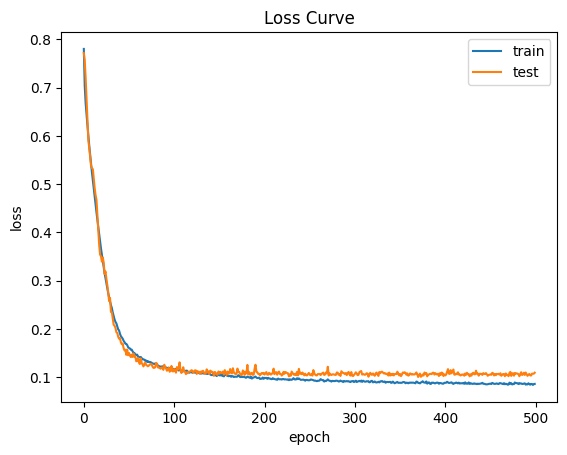

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(train_losses, label="train")
plt.plot(test_losses, label="test")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.title("Loss Curve")
plt.show()

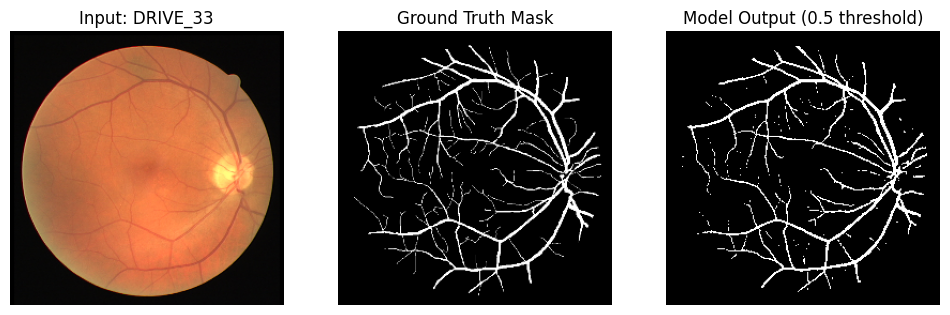

In [ ]:
import torch

model.eval()

with torch.no_grad():
    images, masks, names = next(iter(test_loader))
    images = images.to(device)
    outputs = model(images)
    if outputs.shape[1] == 1:
        preds = torch.sigmoid(outputs)
    else:
        preds = outputs

    img = images[0].cpu().permute(1,2,0).numpy()
    gt = masks[0].cpu().squeeze().numpy()
    pred = preds[0].cpu().squeeze().numpy()

    pred_bin = (pred > 0.5).astype('float32')

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.title(f"Input: {names[0]}")
plt.imshow(img)
plt.axis("off")

plt.subplot(1,3,2)
plt.title("Ground Truth Mask")
plt.imshow(gt, cmap="gray")
plt.axis("off")

plt.subplot(1,3,3)
plt.title("Model Output (0.5 threshold)")
plt.imshow(pred_bin, cmap="gray")
plt.axis("off")

plt.show()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RetinaLiteNet().to(device)
model.load_state_dict(torch.load("/content/drive/MyDrive/DL Final Project/model_final.pth", map_location=device))
model.eval()

def jaccard(pred, target, eps=1e-6):
    pred = pred.float()
    target = target.float()
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    return (intersection + eps) / (union + eps)

def dice(pred, target, eps=1e-6):
    pred = pred.float()
    target = target.float()
    intersection = (pred * target).sum()
    return (2 * intersection + eps) / (pred.sum() + target.sum() + eps)

def sensitivity(pred, target, eps=1e-6):
    pred = pred.float()
    target = target.float()
    tp = (pred * target).sum()
    fn = ((1 - pred) * target).sum()
    return (tp + eps) / (tp + fn + eps)

def specificity(pred, target, eps=1e-6):
    pred = pred.float()
    target = target.float()
    tn = ((1 - pred) * (1 - target)).sum()
    fp = (pred * (1 - target)).sum()
    return (tn + eps) / (tn + fp + eps)

jac_list, dice_list, sen_list, spec_list = [], [], [], []

with torch.no_grad():
    for images, masks, _ in test_loader:
        images = images.to(device)
        masks = masks.to(device)

        logits = model(images)
        preds = (torch.sigmoid(logits) > 0.5).float()

        for p, t in zip(preds, masks):
            jac_list.append(jaccard(p, t).item())
            dice_list.append(dice(p, t).item())
            sen_list.append(sensitivity(p, t).item())
            spec_list.append(specificity(p, t).item())

print("Mean Jaccard (IoU):", sum(jac_list)/len(jac_list))
print("Mean F1 (Dice):    ", sum(dice_list)/len(dice_list))
print("Mean Sensitivity:  ", sum(sen_list)/len(sen_list))
print("Mean Specificity:  ", sum(spec_list)/len(spec_list))


Mean Jaccard (IoU): 0.6071682373682658
Mean F1 (Dice):     0.7551252146561941
Mean Sensitivity:   0.7292015254497528
Mean Specificity:   0.9835430185000101
